<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/tasks/speech-recognition-from-scratch.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/tasks/speech-recognition-from-scratch.ipynb)

# Speech Recognition From Scratch

Ready to dive into the world of building your own speech recognizer using SpeechBrain?

You're in luck because this tutorial is what you are looking for! We'll guide you through the whole process of setting up an offline **end-to-end attention-based speech recognizer**.

But before we jump in, let's take a quick look at speech recognition and check out the cool techniques that SpeechBrain brings to the table.

Let's get started! 🚀


## Overview of Speech Recognition
In the figure, we show an example of a typical speech recognition pipeline used in SpeechBrain:


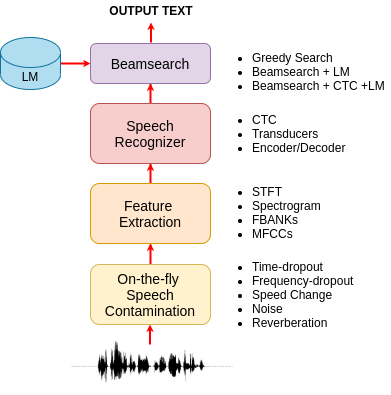




The speech recognition process begins with the **raw waveform directly 🎤**.

The original waveform undergoes contamination through various **speech augmentation techniques**, such as *time/frequency dropout*, *speed change*, *adding noise*, *reverberation*, etc. These disturbances are activated randomly based on user-specified probabilities and are applied **on-the-fly** without the need to store augmented signals on disk.

For a deeper understanding of the contamination techniques, check out our tutorials on [speech augmentation](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-augmentation.html) and [environmental corruption](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/environmental-corruption.html).

Next, we extract **speech features**, such as *Short-Term Fourier Transform (STFT)*, *spectrograms*, *FBANKs*, and *MFCCs*. Thanks to a highly efficient GPU-friendly implementation, these features can be computed on the fly.

For more detailed information, refer to our tutorials on [speech representation](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/fourier-transform-and-spectrograms.html) and [speech features](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-features.html).

Subsequently, the features are fed into the **speech recognizer**, a neural network mapping input feature sequences to output token sequences (e.g., phonemes, characters, subwords, words). SpeechBrain supports popular techniques like Connectionist Temporal Classification (CTC), Transducers, or Encoder/Decoder with attention (using both RNN- and Transformer-based systems).

Posterior probabilities over output tokens are processed by a beamsearcher that explores alternatives and outputs the best one. Optionally, alternatives can be rescored with an external language model, which may be based on RNN or transformers 🤖.

Not all modules mentioned are mandatory; for example, data contamination can be skipped if not helpful for a specific task. Even beam search can be replaced with a greedy search for fast decoding.

Now, let's delve into a more detailed discussion of the different technologies supported for speech recognition: 🚀

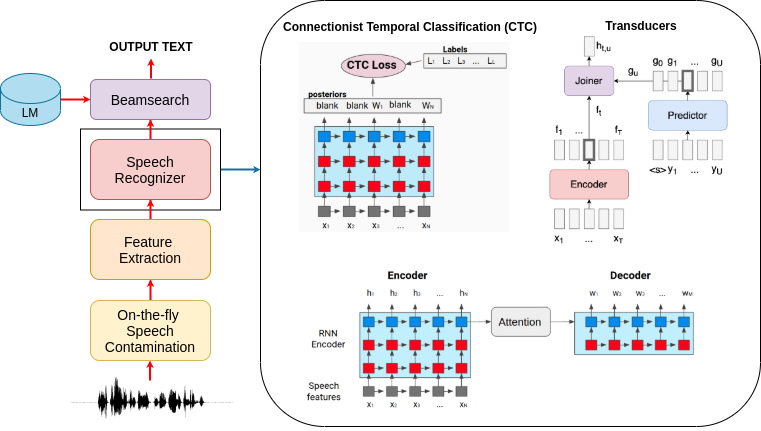


### Connectionist Temporal Classification (CTC)

CTC stands out as the simplest speech recognition system within SpeechBrain.

At each time step, it produces a prediction. CTC introduces a unique token, *blank*, enabling the network to output nothing when uncertain. The CTC cost function employs **dynamic programming** to align across all possible alignments.

For each alignment, a corresponding probability can be computed. The ultimate CTC cost is the sum of the probabilities of all possible alignments, efficiently calculated using the forward algorithm (distinct from the one used in neural networks, as described in Hidden Markov Model literature).

In encoder-decoder architectures, attention is used to learn the alignment between input-output sequences. In CTC, alignment isn't learned; instead, integration occurs over all possible alignments.

Essentially, CTC implementation involves incorporating a specialized cost function atop the speech recognizer, often based on recurrent neural networks (RNNs), although not exclusively. 🧠




### Transducers

In the depicted figure, Transducers enhance CTC by introducing an autoregressive predictor and a join network.

An encoder converts input features into a sequence of encoded representations. The predictor, on the other hand, generates a latent representation based on previously emitted outputs. A join network amalgamates these two, and a softmax classifier predicts the current output token. During training, CTC loss is applied after the classifier.

For more in-depth insights into Transducers, check out this informative tutorial by Loren Lugosch: [Transducer Tutorial](https://lorenlugosch.github.io/posts/2020/11/transducer/) 📚.

### Encoder-Decoder with Attention 👂

Another widely-used approach in speech recognition involves employing an encoder-decoder architecture.

- The **encoder** processes a sequence of speech features (or raw samples directly) to generate a sequence of states, denoted as h.
- The **decoder** utilizes the last hidden state and produces N output tokens. Typically, the decoder is autoregressive, with the previous output fed back into the input. Decoding halts upon predicting the end-of-sentence (eos) token.
- Encoders and decoders can be constructed using various neural architectures, such as RNNs, CNNs, Transformers, or combinations of them.

The inclusion of **attention** facilitates dynamic connections between encoder and decoder states. SpeechBrain supports different attention types, including *content* or *location-aware* for RNN-based systems and *key-value*-based for Transformers. As a convergence enhancement, a CTC loss is often applied atop the encoder. 🚀

This architecture provides flexibility and adaptability, allowing for effective speech recognition across diverse applications.

### Beamsearch
The beamsearcher employed in encoder-decoder models follows an autoregressive process. Here's how it operates:

1. Initialization: The process begins with the <bos> (beginning-of-sequence) token.
2. Prediction: The model predicts the N most promising next tokens based on the current input.
3. Feeding Alternatives: These N alternatives are fed into the decoder to generate future hypotheses.
4. Selection: The best N hypotheses are chosen based on certain criteria or scoring mechanisms.
5. Iteration: The loop continues until the <eos> (end-of-sequence) token is predicted.


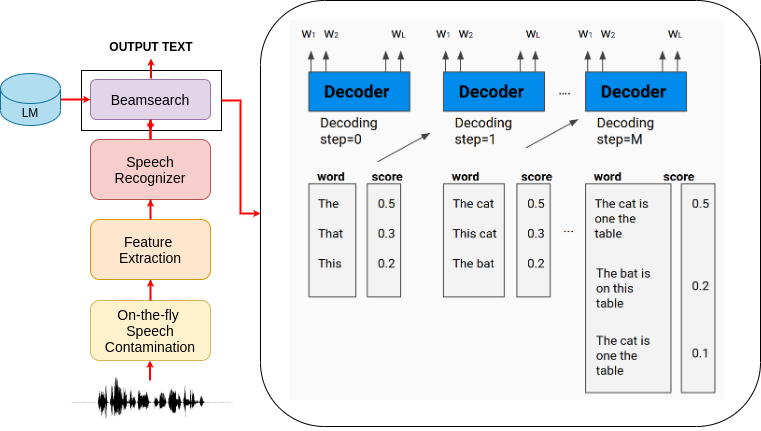


We encourage the readers not familiar enough with speech recognition to gain more familiarity with this technology before moving on. Beyond scientific papers, online you can find amazing tutorials and blog posts, such as:
- [An Intuitive Explanation of Connectionist Temporal Classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Connectionist Temporal Classification](https://web.archive.org/web/20211017041333/https://machinelearning-blog.com/2018/09/05/753/)
- [Sequence-to-sequence learning with Transducers](https://lorenlugosch.github.io/posts/2020/11/transducer/)
- [Understanding Encoder-Decoder Sequence to Sequence Model](https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346)
- [What is a Transformer?](https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04)
- [Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
- [Attention and its Different Forms](https://towardsdatascience.com/attention-and-its-different-forms-7fc3674d14dc)
- [How to Implement a Beam Search Decoder for Natural Language Processing](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)
- [An intuitive explanation of Beam Search](https://towardsdatascience.com/an-intuitive-explanation-of-beam-search-9b1d744e7a0f)

After this brief overview let's now see how we can develop a speech recognition system (encoder-decoder + CTC) with SpeechBrain.

For simplicity, training will be done with a small open-source dataset called [mini-librispeech](https://www.openslr.org/31/), which only contains few hours of training data. In a real case, you need much more training material (e.g 100 or even 1000 hours) to reach acceptable performance.

## Installation

To run the code fast enough, we suggest using a GPU (`Runtime => change runtime type => GPU`). In this tutorial, we will refer to the code in ```speechbrain/templates/ASR```.

Before starting, let's install speechbrain:

In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/

## Which steps are needed?

### 1. Prepare Your Data 
   - Create data manifest files (CSV or JSON format) specifying the location of speech data and corresponding text annotations.
   - Utilize tools like [mini_librispeech_prepare.py](https://github.com/speechbrain/speechbrain/blob/develop/templates/speech_recognition/mini_librispeech_prepare.py) to generate these manifest files.

### 2. Train a Tokenizer 
   - Decide on basic units for training the speech recognizer and language model (e.g., characters, phonemes, sub-words, words).
   - Execute the tokenizer training script:
     ```bash
     cd speechbrain/templates/speech_recognition/Tokenizer
     python train.py tokenizer.yaml
     ```

### 3. Train a Language Model 
   - Train a language model using a large text corpus (preferably within the same language domain as your target application).
   - Example training script for a language model:
     ```bash
     pip install datasets
     cd speechbrain/templates/speech_recognition/LM
     python train.py RNNLM.yaml
     ```

### 4. Train the Speech Recognizer 
   - Train the speech recognizer using a chosen model (e.g., CRDNN) with an autoregressive GRU decoder and attention mechanism.
   - Employ beamsearch along with the trained language model for sequence generation:
     ```bash
     cd speechbrain/templates/speech_recognition/ASR
     python train.py train.yaml
     ```

### 5. Use the Speech Recognizer (Inference) 
   - After training, deploy the trained speech recognizer for inference.
   - Leverage classes like EncoderDecoderASR in SpeechBrain to simplify the inference process.

Each step is crucial for building an effective end-to-end speech recognizer.

We will now provide a detailed description of all these steps.


## Step 1: Prepare Your Data 

Data preparation is a critical initial step in training an end-to-end speech recognizer. Its primary objective is to generate data manifest files, which instruct SpeechBrain on the locations of audio data and their corresponding transcriptions. These manifest files, written in widely-used CSV and JSON formats, play a crucial role in organizing the training process.

### Data Manifest Files

Let's delve into the structure of a data manifest file in JSON format:

```json
{
  "1867-154075-0032": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0032.flac",
    "length": 16.09,
    "words": "AND HE BRUSHED A HAND ACROSS HIS FOREHEAD AND WAS INSTANTLY HIMSELF CALM AND COOL VERY WELL THEN IT SEEMS I'VE MADE AN ASS OF MYSELF BUT I'LL TRY TO MAKE UP FOR IT NOW WHAT ABOUT CAROLINE"
  },
  "1867-154075-0001": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0001.flac",
    "length": 14.9,
    "words": "THAT DROPPED HIM INTO THE COAL BIN DID HE GET COAL DUST ON HIS SHOES RIGHT AND HE DIDN'T HAVE SENSE ENOUGH TO WIPE IT OFF AN AMATEUR A RANK AMATEUR I TOLD YOU SAID THE MAN OF THE SNEER WITH SATISFACTION"
  },
  "1867-154075-0028": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0028.flac",
    "length": 16.41,
    "words": "MY NAME IS JOHN MARK I'M DOONE SOME CALL ME RONICKY DOONE I'M GLAD TO KNOW YOU RONICKY DOONE I IMAGINE THAT NAME FITS YOU NOW TELL ME THE STORY OF WHY YOU CAME TO THIS HOUSE OF COURSE IT WASN'T TO SEE A GIRL"
  },
}
```

This structure follows a hierarchical format where the unique identifier of the spoken sentence serves as the first key. Key fields such as the path of the speech recording, its length in seconds, and the sequence of words uttered are specified for each entry.

A special variable, `data_root`, allows dynamic changes to the data folder from the command line or the YAML hyperparameter file.

### Preparation Script

Creating a preparation script for your specific dataset is essential, considering that each dataset has its own format. For instance, the [mini_librispeech_prepare.py](https://github.com/speechbrain/speechbrain/blob/develop/templates/speech_recognition/mini_librispeech_prepare.py) script, tailored for the mini-librispeech dataset, serves as a foundational template. This script automatically downloads publicly available data, searches for audio files and transcriptions, and creates the JSON file.

Use this script as a starting point for custom data preparation on your target dataset. It offers a practical guide for organizing training, validation, and test phases through three separate data manifest files.

### Copy Your Data Locally

In an HPC cluster or similar environments, optimizing code performance involves copying data to the local folder of the computing node. While not applicable in Google Colab, this practice significantly accelerates code execution by fetching data from the local filesystem instead of the shared one.

Take note of these considerations as you embark on the crucial journey of data preparation for training your speech recognizer. 🚀🎙️



## Step 2: Tokenizer

Choosing the basic tokens for your speech recognizer is a critical decision that impacts the model's performance. You have several options, each with its own set of advantages and challenges.

### Using Characters as Tokens
One straightforward approach is to predict characters, converting the sequence of words into a sequence of characters. For example:
```
THE CITY OF MONTREAL => ['T','H','E', '_', 'C','I','T','Y','_', 'O', 'F', '_, 'M','O','N','T','R','E','A','L']
```
Advantages and disadvantages of this approach include a small total number of tokens, the chance to generalize to unseen words, and the challenge of predicting long sequences.

### Using Words as Tokens
Predicting full words is another option:
```
THE CITY OF MONTREAL => ['THE','CITY','OF','MONTREAL']
```
Advantages include short output sequences, but the system can't generalize to new words, and tokens with little training material may be allocated.

### Byte Pair Encoding (BPE) Tokens
A middle ground is Byte Pair Encoding (BPE), a technique inherited from data compression. It allocates tokens for the most frequent sequences of characters:
```
THE CITY OF MONTREAL => ['THE', '▁CITY', '▁OF', '▁MO', 'NT', 'RE', 'AL']
```
BPE finds tokens based on the most frequent character pairs, allowing for flexibility in token length.

#### How Many BPE Tokens?
The number of tokens is a hyperparameter that depends on the available speech data. For reference, 1k to 10k tokens are reasonable for datasets like LibriSpeech (1000 hours of English sentences).

### Train a Tokenizer
SpeechBrain leverages [SentencePiece](https://github.com/google/sentencepiece) for tokenization. To find the tokens for your training transcriptions, run the following code:

```bash
cd speechbrain/templates/speech_recognition/Tokenizer
python train.py tokenizer.yaml
```

This step is crucial in shaping the behavior of your speech recognizer. Experiment with different tokenization strategies to find the one that best suits your dataset and objectives. 🚀🔍

Let's train the tokenizer:

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
!python train.py tokenizer.yaml

The code might take a while just because data are downloaded and prepared. As for all the other recipes in SpeechBrain, we have a training script (`train.py`) and a hyperparameter file (`tokenizer.yaml`). Let's take a closer look into the latter first:



```yaml
# ############################################################################
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################


# Set up folders for reading from and writing to
data_folder: ../data
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train.json
valid_annotation: ../valid.json
test_annotation: ../test.json

# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
token_output: 1000  # index(blank/eos/bos/unk) = 0
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   vocab_size: !ref <token_output>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json
```

The tokenizer is trained on training annotations only. We set here a vocabulary size of 1000. Instead of using the standard BPE algorithm, we use a variation of it based on unigram smoothing. See [sentencepiece](https://github.com/google/sentencepiece) for more info.
The tokenizer will be saved in the specified `output_folder`.

Let's now take a look into the training script `train.py`:



```python
if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_mini_librispeech(
        data_folder=hparams["data_folder"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
    )

    # Train tokenizer
    hparams["tokenizer"]()
```

Essentially, we prepare the data with the `prepare_mini_librispeech` script and we then run the sentencepiece tokenizer wrapped in
`speechbrain.tokenizers.SentencePiece.SentencePiece`.

Let's take a look at the files generated by the tokenizer. If you go into the specified output folder (`Tokenizer/save`), you can find two files:
+ *1000_unigram.model*
+ *1000_unigram.vocab*

The first is a binary file containing all the information needed for tokenizing an input text. The second is a text file reporting the list of tokens allocated (with their log probabilities):

```
▁THE  -3.2458
S -3.36618
ED  -3.84476
▁ -3.91777
E -3.92101
▁AND  -3.92316
▁A  -3.97359
▁TO -4.00462
▁OF -4.08116
....
```

Let me now show how we can use the learned model to tokenize a text:


In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_ids('THE CITY OF MONTREAL'))


Note that the sentencepiece tokenizers also assign a unique index to each allocated token. These indexes will correspond to the output of our neural networks for language models and ASR.

## Step 3: Train a Language Model 

A Language Model (LM) plays a crucial role in enhancing the performance of a speech recognizer. In this tutorial, we adopt the concept of **shallow fusion**, incorporating language information within the beam searcher of the speech recognizer to rescore partial hypotheses. This involves scoring the partial hypotheses provided by the speech recognizer with language scores, penalizing sequences of tokens that are "unlikely" to be observed.

### Text Corpus
Training a language model typically involves using large text corpora, predicting the most probable next token. If you lack a substantial text corpus for your application, you may choose to skip this part. Additionally, training a language model on a large text corpus is computationally demanding, so consider leveraging pre-trained models and fine-tuning if needed.

For the purposes of this tutorial, we train a language model on the training transcriptions of mini-librispeech. Keep in mind that this is a simplified demonstration for educational purposes.

### Train a LM

We are going to train a simple RNN-based language model that estimates the next tokens given the previous ones.

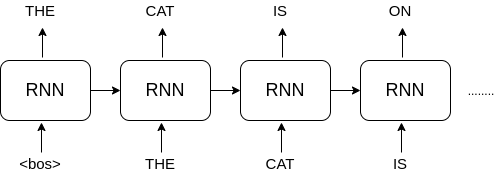

To train it, run the following code:

In [ ]:
!pip install datasets
%cd /content/speechbrain/templates/speech_recognition/LM
!python train.py RNNLM.yaml #--device='cpu'

As evident from the output, both training and validation losses exhibit a consistent decrease over time.

Before delving into the code, let's explore the contents generated within the specified `output_folder`:

*   `train_log.txt`: This file comprises statistics (e.g., train_loss, valid_loss) computed at each epoch.
*   `log.txt`: A detailed logger providing timestamps for each fundamental operation.
*   `env.log`: Displays all dependencies used along with their respective versions, facilitating replicability.

*   `train.py`, `hyperparams.yaml`: Copies of the experiment file along with corresponding hyperparameters, crucial for ensuring replicability.

*   `save`: The repository where the learned model is stored.

Within the `save` folder, subfolders contain checkpoints saved during training, formatted as `CKPT+data+time`. Typically, two checkpoints reside here: the best (i.e., the oldest, representing optimal performance) and the latest (i.e., the most recent). If a single checkpoint is present, it indicates that the last epoch is also the best.

Each checkpoint folder encompasses all information necessary for resuming training, including models, optimizers, schedulers, epoch counters, etc. The parameters of the RNNLM model are stored in the `model.ckpt` file, utilizing a binary format readable with `torch.load`.

The hyperparameters section of the tutorial provides a comprehensive overview of the settings used for training the language model. Here's a refined version of the explanation:

### Hyperparameters

For a detailed look at the complete `RNNLM.yaml` file, please refer to [this link](https://github.com/speechbrain/speechbrain/blob/develop/templates/speech_recognition/LM/RNNLM.yaml).

In the initial section, fundamental configurations such as the random seed, output folder paths, and training logger are defined:

```yaml
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
```

The subsequent segment outlines the paths for the text corpora used in training, validation, and testing:

```yaml
lm_train_data: data/train.txt
lm_valid_data: data/valid.txt
lm_test_data: data/test.txt
```

Unlike other recipes, the Language Model (LM) directly processes large raw text corpora without the need for JSON/CSV files, leveraging the [HuggingFace dataset](https://huggingface.co/) for efficiency.

Following this, the setup for the train logger and the specification of the tokenizer (utilizing the one trained in the previous step) are detailed:

```yaml
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

tokenizer_file: ../Tokenizer/save/1000_unigram.model
```

Moving on, essential training hyperparameters, including epochs, batch size, and learning rate, are defined, along with critical architectural parameters such as embedding dimension, RNN size, layers, and output dimensionality:

```yaml
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1
ckpt_interval_minutes: 15

emb_dim: 256
rnn_size: 512
layers: 2
output_neurons: 1000
```

Subsequently, the objects for training the language model are introduced, encompassing the RNN model, cost function, optimizer, and learning rate scheduler:

```yaml
model: !new:templates.speech_recognition.LM.custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>

compute_cost: !name:speechbrain.nnet.losses.nll_loss

optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0
```

The YAML file concludes with the specification of the epoch counter, tokenizer, and checkpointer:

```yaml
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

modules:
    model: !ref <model>

tokenizer: !new:sentencepiece.SentencePieceProcessor

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>
```

The pre-trainer class facilitates the connection between the tokenizer object and the pre-trained tokenizer file.




### Experiment file
Let's now take a look into how the objects, functions, and hyperparameters declared in the yaml file are used in `train.py` to implement the language model.

Let's start from the main of the `train.py`:


```python
# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )
```

We here do some preliminary operations such as parsing the command line, initializing the distributed data-parallel (needed if multiple GPUs are used), creating the output folder, and reading the yaml file.

After reading the yaml file with `load_hyperpyyaml`, all the objects declared in the hyperparameter files are initialized and available in a dictionary form (along with the other functions and parameters reported in the yaml file).
For instance,  we will have `hparams['model']`, `hparams['optimizer']`, `hparams['batch_size']`, etc.


#### Data-IO Pipeline
We then call a special function that creates the dataset objects for training, validation, and test.

```python
    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)
```

Let's take a closer look into that.


```python
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data
```

The first part is just a conversion from the HuggingFace dataset to the DynamicItemDataset used in SpeechBrain.

You can notice that we expose the text processing function `text_pipeline`, which takes in input the text of one sentence and processes it in different ways.

The text processing function converts the raw text into the corresponding tokens (in index form). We also create other variables such as the version of the sequence with the beginning of the sentence `<bos>`  token in front and the one with the end of sentence `<eos>` as the last element. Their usefulness will be clear later.

Before returning the dataset objects, the `dataio_prepare` specifies which keys we would like to output. As we will see later, these keys will be available in the brain class as `batch.id`, `batch.text`, `batch.tokens_bos`, etc.
[For more information on the data loader, please take a look into this tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/data-loading-pipeline.html)


After the definition of the datasets, the main function can go ahead with the  initialization of the brain class:

```python
    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
```
The brain class implements all the functionalities needed for supporting the training and validation loops.  Its `fit` and `evaluate` methods perform training and test, respectively:

```python
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )
```
The training and validation data loaders are given in input to the fit method, while the test dataset is fed into the evaluate method.

Let's now take a look into the most important methods defined in the brain class.

#### Forward Computations

Let's start with the `forward` function, which defines all the computations needed to transform the input text into the output predictions.


```python
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        pred = self.hparams.model(tokens_bos)
        return pred
```

In this case, the chain of computation is very simple. We just put the batch on the right device and feed the encoded tokens into the model. We feed the tokens with `<bos>` into the model.
When adding the `<bos>` token, in fact, we shift all the tokens by one element. This way, our input corresponds to the previous token while our model tries to predict the current one.

#### Compute Objectives

Let's take a look now into the `compute_objectives` method that takes in input the targets, the predictions, and estimates a loss function:

```python
    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss
```
The predictions are those computed in the forward method. The cost function is evaluated by comparing these predictions with the target tokens. We here use the tokens with the special `<eos>` token at the end because we want to predict when the sentence ends as well.

####**Other methods**
Beyond these two important functions, we have some other methods that are used by the brain class. In particular, the `fit_batch` trains each batch of data (by computing the gradient with the backward method and the updates with step one). The `on_stage_end`, is called at the end of each stage (e.g, at the end of each training epoch) and mainly takes care of statistic management, learning rate annealing, and checkpointing. [For a more detailed description of the brain class, please take a look into this tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/brain-class.html). For more information on checkpointing, [take a look here](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/checkpointing.html)





### Step 4: Training the Attention-Based End-to-End Speech Recognizer

Now it's time to train our attention-based end-to-end speech recognizer. This offline recognizer employs a sophisticated architecture, utilizing a combination of convolutional, recurrent, and fully connected models in the encoder, and an autoregressive GRU decoder.

The crucial link between the encoder and decoder is an attention mechanism. To enhance performance, the final sequence of words is obtained through beam search, coupled with the previously trained RNNLM.

#### Architecture Overview:
- **Encoder:** Combines convolutional, recurrent, and fully connected models.
- **Decoder:** Autoregressive GRU decoder.
- **Attention Mechanism:** Enhances information flow between the encoder and decoder.
- **CTC (Connectionist Temporal Classification):** Jointly trained with the attention-based system, applied on top of the encoder.
- **Data Augmentation:** Employed techniques to augment data and improve overall system performance.


### Train the speech recognizer
To train the speech recognizer, run the following code:

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/ASR
!python train.py train.yaml --number_of_epochs=1  --batch_size=2  --enable_add_reverb=False --enable_add_noise=False #To speed up

Executing this code may require a considerable amount of time on Google Colab. Monitoring the log, you'll observe a progressive improvement in loss after each epoch.

Similar to the RNNLM section, the specified `output_folder` will include the previously discussed files and folders. Additionally, a file named `wer.txt` is saved, providing a comprehensive report on the Word Error Rate (WER) achieved for each test sentence. This file not only captures the WER values but also includes the alignment information with the true transcription for enhanced analysis:


```
%WER 3.09 [ 1622 / 52576, 167 ins, 171 del, 1284 sub ]
%SER 33.66 [ 882 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
================================================================================
ALIGNMENTS

Format:
<utterance-id>, WER DETAILS
<eps> ; reference  ; on ; the ; first ;  line
  I   ;     S      ; =  ;  =  ;   S   ;   D  
 and  ; hypothesis ; on ; the ; third ; <eps>
================================================================================
672-122797-0033, %WER 0.00 [ 0 / 2, 0 ins, 0 del, 0 sub ]
A ; STORY
= ;   =  
A ; STORY
================================================================================
2094-142345-0041, %WER 0.00 [ 0 / 1, 0 ins, 0 del, 0 sub ]
DIRECTION
    =    
DIRECTION
================================================================================
2830-3980-0026, %WER 50.00 [ 1 / 2, 0 ins, 0 del, 1 sub ]
VERSE ; TWO
  S   ;  =
FIRST ; TWO
================================================================================
237-134500-0025, %WER 50.00 [ 1 / 2, 0 ins, 0 del, 1 sub ]
OH ;  EMIL
=  ;   S  
OH ; AMIEL
================================================================================
7127-75947-0012, %WER 0.00 [ 0 / 2, 0 ins, 0 del, 0 sub ]
INDEED ; AH
  =    ; =
INDEED ; AH
================================================================================

```



Let's now take a closer look into the hyperparameter (`train.yaml`)  and experiment script (`train.py`).


### Hyperparameters

The hyperparameter file starts with the definition of basic things, such as seed and path settings:

```yaml
# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set data_folder with the local path
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.

data_folder: ../data # In this case, data will be automatically downloaded here.
data_folder_noise: !ref <data_folder>/noise # The noisy sequencies for data augmentation will automatically be downloaded here.
data_folder_rir: !ref <data_folder>/rir # The impulse responses used for data augmentation will automatically be downloaded here.

# Data for augmentation
NOISE_DATASET_URL: https://www.dropbox.com/scl/fi/a09pj97s5ifan81dqhi4n/noises.zip?rlkey=j8b0n9kdjdr32o1f06t0cw5b7&dl=1
RIR_DATASET_URL: https://www.dropbox.com/scl/fi/linhy77c36mu10965a836/RIRs.zip?rlkey=pg9cu8vrpn2u173vhiqyu743u&dl=1

output_folder: !ref results/CRDNN_BPE_960h_LM/<seed>
test_wer_file: !ref <output_folder>/wer_test.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech


# Path where data manifest files will be stored. The data manifest files are created by the
# data preparation script
train_annotation: ../train.json
valid_annotation: ../valid.json
test_annotation: ../test.json
noise_annotation: ../noise.csv
rir_annotation: ../rir.csv

skip_prep: False

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>
```

The `data_folder` corresponds to the path where the mini-librispeech is stored. If not available, the mini-librispeech dataset will be downloaded here. As mentioned, the script also supports data augmentation. To do it, we use the impulse responses and noise sequences of the open rir dataset (again, if not available it will be downloaded here).

We also specify the folder where the language model is saved. In this case, we use the official pre-trained language model available on HuggingFace, but you can change it and use the one trained at the previous step (you should point to the checkpoint in the folder where the best `model.cpkt` is stored).
What is important is that the set of tokens used for the LM and the one used for training the speech recognizer match exactly.

We also have to specify the data manifest files for training, validation, and test. If not available, these files will be created by the data preparation script called in `train.py`.

After that, we define a bunch of parameters for training, feature extraction, model definition, and decoding:

```yaml
# Training parameters
number_of_epochs: 15
number_of_ctc_epochs: 5
batch_size: 8
lr: 1.0
ctc_weight: 0.5
sorting: ascending
ckpt_interval_minutes: 15 # save checkpoint every N min
label_smoothing: 0.1

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # Number of tokens (same as LM)
blank_index: 0
bos_index: 0
eos_index: 0
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_beam_size: 8
test_beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
ctc_weight_decode: 0.0
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25
```

For instance, we define the number of epochs, the initial learning rate, the batch size, the weight of the CTC loss, and many others.

By setting sorting to `ascending`, we sort all the sentences in ascending order before creating the batches. This minimizes the need for zero paddings and thus makes training faster without losing performance (at least in this task with this model).

Many other parameters, such as those for data augmentations, are defined. For the exact meaning of all of them, you can refer to the docstring of the function/class using this hyperparameter.

In the next block, we define the most important classes that are needed to implement the speech recognizer:


```yaml
# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# Feature normalization (mean and std)
normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Added noise and reverb come from OpenRIR dataset, automatically
# downloaded and prepared with this Environmental Corruption class.
env_corrupt: !new:speechbrain.lobes.augment.EnvCorrupt
    openrir_folder: !ref <data_folder_rirs>
    babble_prob: 0.0
    reverb_prob: 0.0
    noise_prob: 1.0
    noise_snr_low: 0
    noise_snr_high: 15

# Adds speech change + time and frequnecy dropouts (time-domain implementation).
augmentation: !new:speechbrain.lobes.augment.TimeDomainSpecAugment
    sample_rate: !ref <sample_rate>
    speeds: [95, 100, 105]

# The CRDNN model is an encoder that combines CNNs, RNNs, and DNNs.
encoder: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False

# Embedding (from indexes to an embedding space of dimension emb_size).
embedding: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

# Linear transformation on the top of the encoder.
ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# Cost definition for the CTC part.
ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    encoder: !ref <encoder>
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    ctc_lin: !ref <ctc_lin>
    seq_lin: !ref <seq_lin>
    normalize: !ref <normalize>
    env_corrupt: !ref <env_corrupt>
    lm_model: !ref <lm_model>

# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <encoder>
      - !ref <embedding>
      - !ref <decoder>
      - !ref <ctc_lin>
      - !ref <seq_lin>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference
```

For instance, we define the function for computing features and normalizing them. We define the class for environmental corruption and data augmentation ([please, see this tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-augmentation.html)), the architecture of the encoder, decoder, and the other models need by the speech recognizer.


We then report the parameters for beasearch:

```yaml
# Define scorers for beam search

# If ctc_scorer is set, the decoder uses CTC + attention beamsearch. This
# improves the performance, but slows down decoding.
ctc_scorer: !new:speechbrain.decoders.scorer.CTCScorer
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    ctc_fc: !ref <ctc_lin>

# If coverage_scorer is set, coverage penalty is applied based on accumulated
# attention weights during beamsearch.
coverage_scorer: !new:speechbrain.decoders.scorer.CoverageScorer
    vocab_size: !ref <output_neurons>

# If the lm_scorer is set, a language model
# is applied (with a weight specified in scorer).
rnnlm_scorer: !new:speechbrain.decoders.scorer.RNNLMScorer
    language_model: !ref <lm_model>
    temperature: !ref <temperature_lm>

# Gathering all scorers in a scorer instance for beamsearch:
# - full_scorers are scorers which score on full vocab set, while partial_scorers
# are scorers which score on pruned tokens.
# - The number of pruned tokens is decided by scorer_beam_scale * beam_size.
# - For some scorers like ctc_scorer, ngramlm_scorer, putting them
# into full_scorers list would be too heavy. partial_scorers are more
# efficient because they score on pruned tokens at little cost of
# performance drop. For other scorers, please see the speechbrain.decoders.scorer.
test_scorer: !new:speechbrain.decoders.scorer.ScorerBuilder
    scorer_beam_scale: 1.5
    full_scorers: [
        !ref <rnnlm_scorer>,
        !ref <coverage_scorer>]
    partial_scorers: [!ref <ctc_scorer>]
    weights:
        rnnlm: !ref <lm_weight>
        coverage: !ref <coverage_penalty>
        ctc: !ref <ctc_weight_decode>

valid_scorer: !new:speechbrain.decoders.scorer.ScorerBuilder
    full_scorers: [!ref <coverage_scorer>]
    weights:
        coverage: !ref <coverage_penalty>

# Beamsearch is applied on the top of the decoder. For a description of
# the other parameters, please see the speechbrain.decoders.S2SRNNBeamSearcher.

# It makes sense to have a lighter search during validation. In this case,
# we don't use scorers during decoding.
valid_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    temperature: !ref <temperature>
    scorer: !ref <valid_scorer>

# The final decoding on the test set can be more computationally demanding.
# In this case, we use the LM + CTC probabilities during decoding as well,
# which are defined in scorer.
# Please, remove scorer if you need a faster decoder.
test_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    temperature: !ref <temperature>
    scorer: !ref <test_scorer>
```
We here employ different hyperparameters for validation and test beamsearch. In particular, a smaller beam size is used for the validation stage. The reason is that validation is done at the end of each epoch and should thus be done quickly. Evaluation, instead, is done only once at the end and we can be more accurate.


Finally, we declare the last objects needed by the training recipes, such as  lr_annealing, optimizer, checkpointer, etc:


```yaml
 This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adadelta
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8

# Functions that compute the statistics to track during the validation step.
error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
    split_tokens: True

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

# This object is used to pretrain the language model and the tokenizers
# (defined above). In this case, we also pretrain the ASR model (to make
# sure the model converges on a small amount of data)
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
    paths:
        lm: !ref <pretrained_path>/lm.ckpt
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        model: !ref <pretrained_path>/asr.ckpt
```

The final object is the pretrainer that links the language model, the tokenizer, and the acoustic speech recognition model with their corresponding files used for pre-training.  We here pre-train the acoustic model as well. One such a small dataset, it is very hard to make an end-to-end speech recognizer converging and we thus use another model to pre-trained it (you should skip this part when training on a larger dataset).

### Experiment file
Let's now see how the different elements declared in the yaml files are connected in the train.py.
The training script closely follows the one already described for the language model.

The `main` function starts with the implementation of basic functionalities such as parsing the command line, initializing the distributed data-parallel (needed for multiple GPU training), and reading the yaml file.



```python

if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    if not hparams["skip_prep"]:
        sb.utils.distributed.run_on_main(
            prepare_mini_librispeech,
            kwargs={
                "data_folder": hparams["data_folder"],
                "save_json_train": hparams["train_annotation"],
                "save_json_valid": hparams["valid_annotation"],
                "save_json_test": hparams["test_annotation"],
            },
        )
    sb.utils.distributed.run_on_main(hparams["prepare_noise_data"])
    sb.utils.distributed.run_on_main(hparams["prepare_rir_data"])

```
The yaml file is read with the `load_hyperpyyaml` function. After reading it,  we will have all the declared object initialized and available with the hparams dictionary along with the other functions and variables (e.g, `hparams['model']`, `hparams['test_search']`,`hparams['batch_size']`).

After that, we run the data preparation that has the goal of creating the data manifest file (if not already available). This operation requires writing some files on a disk. For this reason, we have to use the `sb.utils.distributed.run_on_main` to make sure that this operation is executed by the main process only. This avoids possible conflicts when using multiple GPUs with DDP. For more info on multi-gpu training in Speechbrai, [please see this tutorial](https://speechbrain.readthedocs.io/en/latest/multigpu.html).

#### Data-IO Pipeline
At this point, we can create the dataset object that we will use for training, validation, and test loops:

```python
    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams)
```

This function allows users to fully customize the data reading pipeline. Let's take a closer look into it:

```python
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            replacements={"data_root": data_folder},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting traiing data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets
```

Within `dataio_prepare` we define subfunctions for processing the entries defined in the JSON files.
The first function, called `audio_pipeline` takes the path of the audio signal (`wav`) and reads it. It returns a tensor containing the read speech sentence. The entry in input to this function (i.e, `wav`) must have the same name of the corresponding key in the data manifest file:

```json
  "1867-154075-0032": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0032.flac",
    "length": 16.09,
    "words": "AND HE BRUSHED A HAND ACROSS HIS FOREHEAD AND WAS INSTANTLY HIMSELF CALM AND COOL VERY WELL THEN IT SEEMS I'VE MADE AN ASS OF MYSELF BUT I'LL TRY TO MAKE UP FOR IT NOW WHAT ABOUT CAROLINE"
  },
```

Similarly, we define another function called `text_pipeline` for processing the signal transcriptions and put them in a format usable by the defined model. The function reads the string `words` defined in the JSON file and tokenizes it (outputting the index of each token). It return the sequence of tokens with the special begin-of-sentence `<bos>` token in front, and the version with the end-of-sentence `<eos>` token at the end aswell. We will see later why these additional elements are needed.

We then create the `DynamicItemDataset` and connect it with the processing functions defined above. We define the desired output keys. These keys will be available in the brain class within the batch variable as:
- batch.id
- batch.sig
- batch.words
- batch.tokens_bos
- batch.tokens_eos
- batch.tokens

The last part of the `dataio_prepare` function manages data sorting. In this case, we sort data in ascending order to minimize zero paddings and speeding training up. For more information on the dataloaders, [please see this tutorial](https://colab.research.google.com/drive/1AiVJZhZKwEI4nFGANKXEe-ffZFfvXKwH?usp=sharing)


After the definition of the dataio function, we perform pre-training of the language model, ASR model, and tokenizer:


```python
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])
```
We here use the `run_on_main` wrapper because the ` collect_files` method might need to download the pre-trained model from the web. This operation should be done by a single process only even when using multiple GPUs with DDP).

At this point we initialize the Brain class and use it for running training and evaluation:


```python

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = asr_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )
```

For more information on how the Brain class works, [please see this tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/brain-class.html)
Note that the `fit` and `evaluate` methods take in input the dataset objects as well. From this dataset, a pytorch dataloader is created automatically. The latter creates the batches used for training and evaluation.

When speech sentences with **different lengths** are sampled, zero-padding is performed. To keep track of the real length of each sentence within each batch, the dataloader returns a special tensor containing **relative lengths** as well. For instance, let's assume `batch.sig[0]` to be variable that contains the input waveform as a [batch, time] tensor:

```
tensor([[1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0]])
```
The `batch.sig[1]` will contain the following relative lengths:

```
tensor([0.5000, 0.7500, 1.0000])
```

With this information, we can exclude zero-padded steps from some computations (e.g feature normalization, statistical pooling, loss, etc).

### Why relative lengths instead of absolute lengths?

The preference for relative lengths over absolute lengths stems from the dynamic nature of time resolution within a neural network. Several operations, including pooling, stride convolution, transposed convolution, FFT computation, and others, have the potential to alter the number of time steps in a sequence.

By employing the relative position trick, the calculation of actual time steps at each stage of neural computations becomes more flexible. This is achieved by multiplying the relative length by the total length of the tensor. Consequently, the approach adapts to changes in time resolution introduced by various network operations, ensuring a more robust and adaptable representation of temporal information throughout the neural network's computations.


#### Forward Computations
In the Brain class we have to define some important methods such as:
- `compute_forward`, that specifies all the computations needed to transform the input waveform into the output posterior probabilities)
- `compute_objective`, which computes the loss function given the labels and the predictions performed by the model.

Let's take a look into `compute_forward` first:


```python
    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : dict
            At training time it returns predicted seq2seq log probabilities.
            If needed it also returns the ctc output log probabilities.
            At validation/test time, it returns the predicted tokens as well.
        """
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)

        feats, self.feat_lens = self.prepare_features(stage, batch.sig)
        tokens_bos, _ = self.prepare_tokens(stage, batch.tokens_bos)

        # Running the encoder (prevent propagation to feature extraction)
        encoded_signal = self.modules.encoder(feats.detach())

        # Embed tokens and pass tokens & encoded signal to decoder
        embedded_tokens = self.modules.embedding(tokens_bos.detach())
        decoder_outputs, _ = self.modules.decoder(
            embedded_tokens, encoded_signal, self.feat_lens
        )

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(decoder_outputs)
        predictions = {"seq_logprobs": self.hparams.log_softmax(logits)}

        if self.is_ctc_active(stage):
            # Output layer for ctc log-probabilities
            ctc_logits = self.modules.ctc_lin(encoded_signal)
            predictions["ctc_logprobs"] = self.hparams.log_softmax(ctc_logits)

        elif stage != sb.Stage.TRAIN:
            if stage == sb.Stage.VALID:
                hyps, _, _, _ = self.hparams.valid_search(
                    encoded_signal, self.feat_lens
                )
            elif stage == sb.Stage.TEST:
                hyps, _, _, _ = self.hparams.test_search(
                    encoded_signal, self.feat_lens
                )

            predictions["tokens"] = hyps

        return predictions
```


The function takes the batch variable and the current stage (that can be `sb.Stage.TRAIN`, `sb.Stage.VALID`, or `sb.Stage.TEST`). We then put the batch on the right device, compute the features, and encode them with our CRDNN encoder.
For more information on feature computation, [take a look into this tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-features.html), while for more details on the speech augmentation [take a look here](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-augmentation.html).
After that, we feed our encoded states into an autoregressive attention-based decoder that performs some predictions over the tokens.
At validation and test stages, we apply beamsearch on the top of the token predictions.
Our system applies an additional CTC loss on the top of the encoder. The CTC can be turned off after N epochs if desired.


#### Compute Objectives

Let's take a look now into the compute_objectives function:



```python

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs. We here
        do multi-task learning and the loss is a weighted sum of the ctc + seq2seq
        costs.

        Arguments
        ---------
        predictions : dict
            The output dict from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Compute sequence loss against targets with EOS
        tokens_eos, tokens_eos_lens = self.prepare_tokens(
            stage, batch.tokens_eos
        )
        loss = sb.nnet.losses.nll_loss(
            log_probabilities=predictions["seq_logprobs"],
            targets=tokens_eos,
            length=tokens_eos_lens,
            label_smoothing=self.hparams.label_smoothing,
        )

        # Add ctc loss if necessary. The total cost is a weighted sum of
        # ctc loss + seq2seq loss
        if self.is_ctc_active(stage):
            # Load tokens without EOS as CTC targets
            tokens, tokens_lens = self.prepare_tokens(stage, batch.tokens)
            loss_ctc = self.hparams.ctc_cost(
                predictions["ctc_logprobs"], tokens, self.feat_lens, tokens_lens
            )
            loss *= 1 - self.hparams.ctc_weight
            loss += self.hparams.ctc_weight * loss_ctc

        if stage != sb.Stage.TRAIN:
            # Converted predicted tokens from indexes to words
            predicted_words = [
                self.hparams.tokenizer.decode_ids(prediction).split(" ")
                for prediction in predictions["tokens"]
            ]
            target_words = [words.split(" ") for words in batch.words]

            # Monitor word error rate and character error rated at
            # valid and test time.
            self.wer_metric.append(batch.id, predicted_words, target_words)
            self.cer_metric.append(batch.id, predicted_words, target_words)

        return loss
```

Based on the predictions and the target we compute the Negative Log Likelihood  loss (NLL) and, if needed, the Connectionist Temporal Classification (CTC) one as well. The two losses are combined with a weight (ctc_weight). At validation or test stages,  we compute the word-error-rate (WER) and the character-error-rate (CER).

### Other Methods
In addition to the primary functions `forward` and `compute_objective`, the code includes `on_stage_start` and `on_stage_end` functions. The former initializes statistic objects, such as Word Error Rate (WER) and Character Error Rate (CER). The latter oversees several critical aspects:

- **Statistics Updates:** Manages the updating of statistics during training.
- **Learning Rate Annealing:** Handles the adjustment of learning rates over epochs.
- **Logging:** Facilitates logging of crucial information during the training process.
- **Checkpointing:** Manages the creation and storage of checkpoints for resumable training.

By incorporating these functions, the code ensures a comprehensive and efficient training pipeline for the speech recognition system.


That's all. You can just run the code and train your speech recognizer.


## Pretrain and Fine-tune

In scenarios where training from scratch might not be the optimal choice, the option to begin with a pre-trained model and fine-tune it becomes valuable.

It's crucial to note that for this approach to work seamlessly, the architecture of your model must precisely match that of the pre-trained model.

One convenient way to implement this is by utilizing the `pretrainer` class in the YAML file. If you aim to pretrain the encoder of the speech recognizer, the following code snippet can be employed:

```yaml
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
 loadables:
     encoder: !ref <encoder>
 paths:
   encoder: !ref <encoder_ptfile>
```

Here, `!ref <encoder>` points to the encoder model defined earlier in the YAML file, while `encoder_ptfile` denotes the path where the pre-trained model is stored.

To execute the pre-training process, ensure that you call the pre-trainer in the `train.py` file:

```python
run_on_main(hparams["pretrainer"].collect_files)
hparams["pretrainer"].load_collected(device=run_opts["device"])
```

It's essential to invoke this function before the `fit` method of the Brain class.

For a more comprehensive understanding and practical examples, please refer to our [tutorial on pre-training and fine-tuning](https://speechbrain.readthedocs.io/en/latest/tutorials/advanced/pre-trained-models-and-fine-tuning-with-huggingface.html). This resource provides detailed insights into leveraging pre-trained models effectively in your speech recognition system.



## Step 5: Inference

At this point, we can use the trained speech recognizer. For this type of ASR model, speechbrain made available some classes ([take a look here](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/inference/ASR.py)) such as the `EncoderDecoderASR` one that can make inference easier. For instance, we can transcribe an audio file with a pre-trained model hosted in our [HuggingFace repository](https://huggingface.co/speechbrain) in solely 4 lines of code:


In [ ]:
from speechbrain.inference.ASR import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="/content/pretrained_model")
audio_file = 'speechbrain/asr-crdnn-rnnlm-librispeech/example.wav'
asr_model.transcribe_file(audio_file)

But, how does this work with your custom ASR system?

### Utilizing Your Custom Speech Recognizer

At this point, you have two options for training and deploying your speech recognizer on your data:


1. **Utilizing Available Interfaces (e.g., `EncoderDecoderASR`):**
    - Considered the most elegant and convenient option.
    - Your model should adhere to certain constraints to fit the proposed interface seamlessly.
    - This approach streamlines the integration of your custom ASR model with existing interfaces, enhancing adaptability and maintainability.

2. **Building Your Own Custom Interface:**
    - Craft an interface tailored precisely to your custom ASR model.
    - Provides the flexibility to address unique requirements and specifications.
    - Ideal for scenarios where existing interfaces do not fully meet your needs.

**Note:** These solutions are not exclusive to ASR and can be extended to other tasks such as speaker recognition and source separation.




#### Using the `EndoderDecoderASR` interface

The EncoderDecoderASR class interface allows you to decouple your trained model from the training recipe and to infer (or encode) on any new audio file in few lines of code. The class has the following methods:

- *encode_batch*: apply the encoder to an input batch and returns some encoded features.
- *transcribe_file*: transcribes the single audio file in input.
- *transcribe_batch*: transcribes the input batch.

In fact, if you fulfill few constraints that we will detail in the next paragraph, you can simply do:

```python
from speechbrain.inference.ASR import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
audio_file = 'your_file.wav'
asr_model.transcribe_file(audio_file)
```

Nevertheless, to allow such a generalization over all the possible EncoderDecoder ASR pipelines, you will have to consider a few constraints when deploying your system:

1. **Necessary modules.** As you can see in the `EncoderDecoderASR` class, the modules defined in your yaml file MUST contain certain elements with specific names. In practice, you need a tokenizer, a decoder, and a decoder. The encoder can simply be a `speechbrain.nnet.containers.LengthsCapableSequential` composed with a sequence of features computation, normalization and model encoding.
```python
    HPARAMS_NEEDED = ["tokenizer"]
    MODULES_NEEDED = [
        "encoder",
        "decoder",
    ]
```

You also need to declare these entities in the YAML file and create the following dictionary called `modules`:

```
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalize>
    model: !ref <enc>

decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>


modules:
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>
```

In this case, `enc` is a CRDNN, but could be any custom neural network for instance.

  **Why do you need to ensure this?** Well, it simply is because these are the modules we call when inferring on the `EncoderDecoderASR` class. Here is an example of the `encode_batch()` function.
```python
[...]
  wavs = wavs.float()
  wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)
  encoder_out = self.modules.encoder(wavs, wav_lens)
return encoder_out
```
  **What if I have a complex asr_encoder structure with multiple deep neural networks and stuffs ?** Simply put everything in a torch.nn.ModuleList in your yaml:
```yaml
asr_encoder: !new:torch.nn.ModuleList
    - [!ref <enc>, my_different_blocks ... ]
```

2. **Call to the pretrainer to load the checkpoints.** Finally, you need to define a call to the pretrainer that will load the different checkpoints of your trained model into the corresponding SpeechBrain modules. In short, it will load the weights of your encoder, language model or even simply load the tokenizer.
```yaml
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        asr: !ref <asr_model>
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
      asr: !ref <asr_model_ptfile>
      lm: !ref <lm_model_ptfile>
      tokenizer: !ref <tokenizer_ptfile>
```
The loadable field creates a link between a file (e.g. `lm` that is related to the checkpoint in `<lm_model_ptfile>`) to a yaml instance (e.g. `<lm_model>`) that is nothing more than your lm.

If you respect these two constraints, it should works! Here, we give a complete example of a yaml that is used for inference only:

```yaml

# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN model
# Decoder: GRU + beamsearch + RNNLM
# Tokens: BPE with unigram
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga 2020
# ############################################################################


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # index(blank/eos/bos) = 0
blank_index: 0

# Decoding parameters
bos_index: 0
eos_index: 0
min_decode_ratio: 0.0
max_decode_ratio: 1.0
beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>

emb: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

dec: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

tokenizer: !new:sentencepiece.SentencePieceProcessor

asr_model: !new:torch.nn.ModuleList
    - [!ref <enc>, !ref <emb>, !ref <dec>, !ref <ctc_lin>, !ref <seq_lin>]

# We compose the inference (encoder) pipeline.
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalize>
    model: !ref <enc>

ctc_scorer: !new:speechbrain.decoders.scorer.CTCScorer
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    ctc_fc: !ref <ctc_lin>

coverage_scorer: !new:speechbrain.decoders.scorer.CoverageScorer
    vocab_size: !ref <output_neurons>

rnnlm_scorer: !new:speechbrain.decoders.scorer.RNNLMScorer
    language_model: !ref <lm_model>
    temperature: !ref <temperature_lm>

scorer: !new:speechbrain.decoders.scorer.ScorerBuilder
    scorer_beam_scale: 1.5
    full_scorers: [
        !ref <rnnlm_scorer>,
        !ref <coverage_scorer>]
    partial_scorers: [!ref <ctc_scorer>]
    weights:
        rnnlm: !ref <lm_weight>
        coverage: !ref <coverage_penalty>
        ctc: !ref <ctc_weight_decode>

decoder: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <emb>
    decoder: !ref <dec>
    linear: !ref <seq_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    temperature: !ref <temperature>
    scorer: !ref <scorer>

modules:
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        asr: !ref <asr_model>
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>


```

As you can see, it is a standard YAMl file, but with a pretrainer that loads the model. It is similar to the yaml file used for training. We only have to remove all the parts that are training-specific (e.g, training parameters, optimizers, checkpointers, etc.) and add the pretrainer and `encoder`, `decoder` elements that links the needed modules with their pre-trained files.

#### Developing your own inference interface

While the `EncoderDecoderASR` class has been designed to be as generic as possible, your might require a more complex inference scheme that better fits your needs.  In this case, you have to develop your own interface. To do so, follow these steps:

1. Create your custom interface inheriting from `Pretrained` (code [here](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/inference/interfaces.py)):


```python
class MySuperTask(Pretrained):
  # Here, do not hesitate to also add some required modules
  # for further transparency.
  HPARAMS_NEEDED = ["mymodule1", "mymodule2"]
  MODULES_NEEDED = [
        "mytask_enc",
        "my_searcher",
  ]
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Do whatever is needed here w.r.t your system
```

This will enable your class to call useful functions such as `.from_hparams()` that fetches and loads based on a HyperPyYAML file, `load_audio()` that loads a given audio file.  Likely, most of the methods that we coded in the Pretrained class will fit your need. If not, you can override them to implement your custom functionality.


2. Develop your interface and the different functionalities. Unfortunately, we can't provide a generic enough example here. You can add **any** function to this class that you think can make inference on your data/model easier and natural. For instance, we can create here a function that simply encodes a wav file using the `mytask_enc` module.
```python
class MySuperTask(Pretrained):
  # Here, do not hesitate to also add some required modules
  # for further transparency.
  HPARAMS_NEEDED = ["mymodule1", "mymodule2"]
  MODULES_NEEDED = [
        "mytask_enc",
        "my_searcher",
  ]
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Do whatever is needed here w.r.t your system
  
  def encode_file(self, path):
        waveform = self.load_audio(path)
        # Fake a batch:
        batch = waveform.unsqueeze(0)
        rel_length = torch.tensor([1.0])
        with torch.no_grad():
          rel_lens = rel_length.to(self.device)
          encoder_out = self.encode_batch(waveform, rel_lens)
        
        return encode_file
```

Now, we can use your Interface in the following way:
```python
from speechbrain.pretrained import MySuperTask

my_model = MySuperTask.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
audio_file = 'your_file.wav'
encoded = my_model.encode_file(audio_file)

```

As you can see, this formalism is extremely flexible and enables you to create a holistic interface that can be used to do anything you want with your pretrained model.

We provide different generic interfaces for E2E ASR, speaker recognition, source separation, speech enhancement, etc. Please have a look [here](https://github.com/speechbrain/speechbrain/blob/develop/recipes/CommonVoice/ASR/seq2seq/train.py) if interested!



## Customize your speech recognizer
In a general case, you might have your own data and you would like to use your own model. Let's comment a bit more on how you can customize your recipe.

**Suggestion**:  start from a recipe that is working (like the one used for this template) and only do the minimal modifications needed to customize it. Test your model step by step. Make sure your model can overfit on a tiny dataset composed of few sentences. If it doesn't overfit there is likely a bug in your model.

### Train with your data
All you have to do when changing the dataset is to update the data preparation script such that we create the JSON files formatted as expected. The `train.py` script expects that the JSON file to be like this:



```json
{
  "1867-154075-0032": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0032.flac",
    "length": 16.09,
    "words": "AND HE BRUSHED A HAND ACROSS HIS FOREHEAD AND WAS INSTANTLY HIMSELF CALM AND COOL VERY WELL THEN IT SEEMS I'VE MADE AN ASS OF MYSELF BUT I'LL TRY TO MAKE UP FOR IT NOW WHAT ABOUT CAROLINE"
  },
  "1867-154075-0001": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0001.flac",
    "length": 14.9,
    "words": "THAT DROPPED HIM INTO THE COAL BIN DID HE GET COAL DUST ON HIS SHOES RIGHT AND HE DIDN'T HAVE SENSE ENOUGH TO WIPE IT OFF AN AMATEUR A RANK AMATEUR I TOLD YOU SAID THE MAN OF THE SNEER WITH SATISFACTION"
  },
```

You have to parse your dataset and create JSON files with a unique ID for each sentence, the path of the audio signal (wav), the length of the speech sentence in seconds (length), and the word transcriptions ("words"). That's all!



### Train with your own model
At some point, you might have your own model and you would like to plug it into the speech recognition pipeline.
For instance, you might wanna replace our CRDNN encoder with something different. To do that, you have to create your own class and specify there the list of computations for your neural network. You can take a look into the models already existing in [speechbrain.lobes.models](https://github.com/speechbrain/speechbrain/tree/develop/speechbrain/lobes/models). If your model is a plain pipeline of computations, you can use the [sequential container](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/lobes/models/CRDNN.py#L14). If the model is a more complex chain of computations, you can create it as an instance of `torch.nn.Module` and define there the `__init__` and `forward` methods like [here](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/lobes/models/Xvector.py#L18).

Once you defined your model, you only have to declare it in the yaml file and use it in `train.py`


**Important:**  
When plugging a new model, you have to tune again the most important hyperparameters of the system (e.g, learning rate, batch size, and the architectural parameters) to make the it working well.






## Conclusion

In this tutorial, we showed how to create an end-to-end speech recognizer from scratch using SpeechBrain. The proposed system contains all the basic ingredients to develop a state-of-the-art system (i.e., data augmentation, tokenization, language models, beamsearch, attention, etc)

We described all the steps using a small dataset only. In a real case you have to train with much more data (see for instance our [LibriSpeech recipes](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech)).

## Related Tutorials
1. [YAML hyperpatameter specification](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/hyperpyyaml.html)
2. [Brain Class](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/brain-class.html)
3. [Checkpointing](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/checkpointing.html)
4. [Data-io](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/data-loading-pipeline.html)
5. [Tokenizer](https://speechbrain.readthedocs.io/en/latest/tutorials/advanced/text-tokenizer.html)
6. [Speech Features](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-features.html)
7. [Speech Augmentation](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-augmentation.html)
8. [Environmental Corruption](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/environmental-corruption.html)
9. [MultiGPU Training](https://speechbrain.readthedocs.io/en/latest/multigpu.html)
10. [Pretrain and Fine-tune](https://speechbrain.readthedocs.io/en/latest/tutorials/advanced/pre-trained-models-and-fine-tuning-with-huggingface.html)





## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```